# Loading data

In [ ]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip -d .

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ratings = (pd.read_csv('./ml-1m/ratings.dat', engine='python', sep='::', names=['user', 'item', 'rating', 'timestamp'])
    .assign(timestamp=lambda df:pd.to_datetime(df.timestamp * 1000000000))
          )

movies = (pd.read_csv('./ml-1m/movies.dat', engine='python', sep='::', names=['item', 'title', 'genres'])
          .assign(genres=lambda df:df.genres.str.split('|').values)
          .set_index('item', drop=False))

# See http://files.grouplens.org/datasets/movielens/ml-1m-README.txt for more details
users = pd.read_csv('./ml-1m/users.dat', engine='python', sep='::', 
                    names=['user', 'gender', 'age', 'occupation', 'zipcode'])\
    .set_index('user', drop=False)

## User-item ratings to features

In [3]:
from sklearn import preprocessing
# flatmap equivalent
from itertools import chain

def columns_to_key_feature_pairs(row, key_column, feature_columns):
    return [(row[key_column], '{}={}'.format(column, row[column])) for column in feature_columns]

def array_column_to_key_feature_pairs(row, key_column, array_column):
    return [(row[key_column], u'{}={}'.format(array_column, value)) for value in row[array_column]]

feature_columns=['user', 'gender', 'occupation', 'zipcode']

user_features = pd.DataFrame.from_records(
    data=chain.from_iterable(
        columns_to_key_feature_pairs(row, key_column='user', feature_columns=feature_columns)
        for _, row in users.iterrows()),
    columns=['user', 'feature'])

print(user_features.shape)
user_features.head(10)

(24160, 2)


,user,feature
0,1,user=1
1,1,gender=F
2,1,occupation=10
3,1,zipcode=48067
4,2,user=2
5,2,gender=M
6,2,occupation=16
7,2,zipcode=70072
8,3,user=3
9,3,gender=M


In [4]:
item_features = pd.DataFrame.from_records(
    data=chain.from_iterable(
        columns_to_key_feature_pairs(row, key_column='item', feature_columns=['item']) +\
            array_column_to_key_feature_pairs(row, key_column='item', array_column='genres')
        for _, row in movies.iterrows()), columns=['item', 'feature'])

print(item_features.shape)
item_features.head()

(10291, 2)


,item,feature
0,1,item=1
1,1,genres=Animation
2,1,genres=Children's
3,1,genres=Comedy
4,2,item=2


In [5]:
keyed_ratings = (ratings[['user', 'item', 'rating']]
    .assign(sample_id=lambda df: np.arange(df.shape[0])))

ratings_and_features = (
    pd.concat([
        pd.merge(keyed_ratings, user_features, on='user', how='inner'),
        pd.merge(keyed_ratings, item_features, on='item', how='inner')],
        axis=0)
    .sort_values('sample_id')
    .drop(['user', 'item'], axis=1))

print(ratings_and_features.shape)
ratings_and_features.head(10)

(7102860, 3)


,rating,sample_id,feature
0,5,0,user=1
1,5,0,gender=F
2,5,0,occupation=10
3,5,0,zipcode=48067
1,5,0,genres=Drama
0,5,0,item=1193
3452,3,1,genres=Children's
3453,3,1,genres=Musical
3451,3,1,genres=Animation
3450,3,1,item=661


In [6]:
# A training sample i will be made of the (y_i = rating_i, X_i= sparse features) (encoded as integers, see later) 
ratings_and_features.head(100).groupby('sample_id').feature.apply(list).head()

sample_id
0    [user=1, gender=F, occupation=10, zipcode=4806...
1    [genres=Children's, genres=Musical, genres=Ani...
2    [occupation=10, zipcode=48067, item=914, user=...
3    [item=3408, zipcode=48067, occupation=10, gend...
4    [item=2355, genres=Animation, genres=Comedy, g...
Name: feature, dtype: object

## Engineering interaction features

To help the `LinearRegression` (although http://contrib.scikit-learn.org/polylearn/ or http://www.libfm.org/ are capable of modelling sparse interactions natively. 

In [7]:
left_features_mask = ratings_and_features.feature.str.startswith('gender')
right_features_mask = ratings_and_features.feature.str.startswith('genres')

def build_interaction_features(df):
    return df.feature_x.str.cat(df.feature_y, sep='&')

interaction_features = (
    pd.merge(
        left=ratings_and_features[left_features_mask].drop('rating', 1),
        right=ratings_and_features[right_features_mask],
        on='sample_id')
    .assign(feature=build_interaction_features)
    .drop(['feature_x', 'feature_y'], axis=1))

print(interaction_features.shape)
interaction_features.head()

(2101815, 3)


,sample_id,rating,feature
0,0,5,gender=F&genres=Drama
1,1,3,gender=F&genres=Children's
2,1,3,gender=F&genres=Musical
3,1,3,gender=F&genres=Animation
4,2,3,gender=F&genres=Musical


In [8]:
featurized_ratings = (pd.concat([ratings_and_features, interaction_features], axis=0)
    .assign(feature=lambda df: df.feature.astype('category'))
    .assign(encoded_feature=lambda df: df.feature.values.codes)
    .sort_values('sample_id'))

print(featurized_ratings.shape)
featurized_ratings.head(10)

(9204675, 4)


,feature,rating,sample_id,encoded_feature
0,user=1,5,0,3783
0,item=1193,5,0,245
1,genres=Drama,5,0,45
0,gender=F&genres=Drama,5,0,8
2,occupation=10,5,0,3764
1,gender=F,5,0,0
3,zipcode=48067,5,0,11411
1,gender=F&genres=Children's,3,1,4
3,gender=F&genres=Animation,3,1,3
7,zipcode=48067,3,1,11411


In [9]:
features_decoder = pd.DataFrame.from_dict({
    'name': featurized_ratings.feature.values.categories,
    'encoded_feature': np.arange(len(featurized_ratings.feature.values.categories))}).set_index('encoded_feature', drop=False)

print(features_decoder.shape)
features_decoder.head()

(13262, 2)


,encoded_feature,name
encoded_feature,,
0,0,gender=F
1,1,gender=F&genres=Action
2,2,gender=F&genres=Adventure
3,3,gender=F&genres=Animation
4,4,gender=F&genres=Children's


## Train/test split

 * Ideally time based split
 * For the sake of simplicity, let's just sample ratings uniformly (breaking the time machine rule)

In [10]:
test = ratings.sample(n=100000, random_state=0).sort_index()
test_sample_ids = test.index.values
train_ratings_mask = ~ratings.index.isin(test_sample_ids)
train = ratings.loc[train_ratings_mask]
train_sample_ids = train.index.values

test_user_items = test[['user', 'item']]

print(train.shape)
print(test.shape)

test.head()

(900209, 4)
(100000, 4)


,user,item,rating,timestamp
14,1,1035,5,2000-12-31 22:29:13
19,1,2797,4,2000-12-31 22:33:59
31,1,3186,4,2000-12-31 22:00:19
36,1,1836,5,2000-12-31 22:02:52
47,1,1207,4,2000-12-31 22:11:59


## Evaluation function

In [11]:
def rmse(predicted_ratings, ground_truth_ratings=test):

    # predicted rating will be nan if no prediction => returning nan as a result if not all test ratings provided
    joined_ratings = pd.merge(
        ground_truth_ratings,
        predicted_ratings, 
        on=['user', 'item'], how='left', suffixes=['_ground_truth', '_predicted'])

    squared_errors = np.power(joined_ratings.rating_ground_truth - joined_ratings.rating_predicted, 2)
    
    return np.sqrt(np.average(squared_errors))

## Linear model based on featurized user-item ratings

Building a simple linear model using gender, genres + gender&genres interactions

In [12]:
features_subset = features_decoder[features_decoder.name.str.contains('gender') | features_decoder.name.str.contains('genres')]

ratings_subset_features = (pd.merge(
        left=featurized_ratings,
        right=features_subset[['encoded_feature']], on='encoded_feature', how='inner')
    .sort_values('sample_id'))

print(ratings_subset_features.shape)
ratings_subset_features.head()

(5203839, 4)


,feature,rating,sample_id,encoded_feature
0,genres=Drama,5,0,45
452682,gender=F,5,0,0
354529,gender=F&genres=Drama,5,0,8
787698,genres=Animation,3,1,40
452683,gender=F,3,1,0


In [13]:
from scipy import sparse

def to_coo(row_indexes, col_indexes, values, shape=None, dtype=np.float64):
    return sparse.coo_matrix((values, (row_indexes, col_indexes)), shape=shape, dtype=dtype)

def to_features_matrix(ratings_features):
    condensed_sample_ids = ratings_features.sample_id.astype('category').values.codes
    features_matrix = to_coo(
        row_indexes=condensed_sample_ids,
        col_indexes=ratings_features.encoded_feature.values,
        values=np.ones_like(condensed_sample_ids))
    return features_matrix

in_train_mask = ratings_subset_features.sample_id.isin(train_sample_ids).values

train_features_matrix = to_features_matrix(ratings_subset_features.loc[in_train_mask])
test_features_matrix = to_features_matrix(ratings_subset_features.loc[~in_train_mask])

print(train_features_matrix.__repr__())
test_features_matrix

<900209x56 sparse matrix of type '<class 'numpy.float64'>'
	with 4684057 stored elements in COOrdinate format>


<100000x56 sparse matrix of type '<class 'numpy.float64'>'
	with 519782 stored elements in COOrdinate format>

In [14]:
from sklearn.linear_model import SGDRegressor, LinearRegression

#m = SGDRegressor(fit_intercept=True, n_iter=10, alpha=.0001, penalty='l2', verbose=True)
m = LinearRegression(fit_intercept=True)
m.fit(X=train_features_matrix, y=train.rating)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
def plot_predicted_distribution(predicted_ratings, ground_truth_ratings=test):
    bins = np.linspace(-.5, 7.5, 9)
    plt.hist(predicted_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, label='predicted')
    plt.hist(ground_truth_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, color='grey', label='ground truth')
    plt.ylabel('rating proportion')
    plt.xlabel('rating value')
    plt.xlim([0, 6]); plt.ylim([0, 1.05])
    plt.xticks(range(1, 6))
    plt.legend(loc=2)

1.0929341986279444

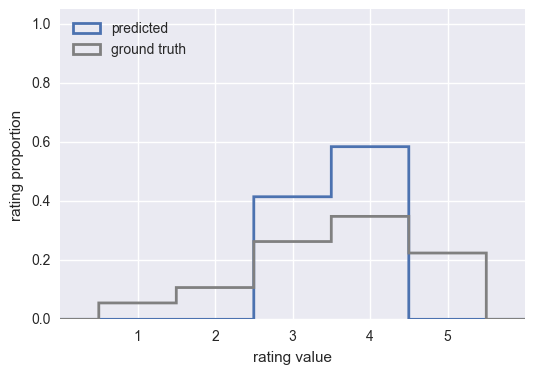

In [16]:
sampled_predicted_ratings = pd.Series(
    index=test_sample_ids,
    data=m.predict(X=test_features_matrix)).to_frame('rating')

user_item_predicted_ratings = sampled_predicted_ratings.join(test_user_items)

plot_predicted_distribution(user_item_predicted_ratings)

rmse(user_item_predicted_ratings)

## Model inspection

Although the model has a poor rmse, it's capturing meaningful trends from the data.

In [17]:
m.intercept_

3.5818259981848661

In [18]:
from scipy.stats import rankdata

top_coefficient_ranks = rankdata(-m.coef_, method='max')
top_coefficients_encoded = np.where(top_coefficient_ranks <= 10)[0]

pd.DataFrame.from_dict(
    {'encoded_feature': top_coefficients_encoded,
     'feature': features_decoder.loc[top_coefficients_encoded].name.values,
     'rating_bias':m.coef_[top_coefficients_encoded]}).sort_values('rating_bias', ascending=False)

,encoded_feature,feature,rating_bias
7,47,genres=Film-Noir,0.285103
5,44,genres=Documentary,0.272388
4,40,genres=Animation,0.213433
1,22,gender=M&genres=Animation,0.191459
9,54,genres=War,0.187840
3,29,gender=M&genres=Film-Noir,0.178453
2,26,gender=M&genres=Documentary,0.158173
6,45,genres=Drama,0.148318
0,12,gender=F&genres=Musical,0.125588
8,49,genres=Musical,0.123122


In [19]:
bottom_coefficient_ranks = rankdata(m.coef_, method='max')
bottom_coefficients_encoded = np.where(bottom_coefficient_ranks <= 10)[0]

pd.DataFrame.from_dict(
    {'encoded_feature': bottom_coefficients_encoded,
     'feature': features_decoder.loc[bottom_coefficients_encoded].name.values,
     'rating_bias':m.coef_[bottom_coefficients_encoded]}).sort_values('rating_bias', ascending=True)

,encoded_feature,feature,rating_bias
9,48,genres=Horror,-0.205708
5,23,gender=M&genres=Children's,-0.195847
8,41,genres=Children's,-0.189144
1,11,gender=F&genres=Horror,-0.133317
4,19,gender=M,-0.092852
7,38,genres=Action,-0.072528
6,30,gender=M&genres=Horror,-0.072391
3,18,gender=F&genres=Western,-0.058713
0,1,gender=F&genres=Action,-0.045851
2,15,gender=F&genres=Sci-Fi,-0.038426
